# Audio Processing & Hash Collision Analysis for TuneTracker

This notebook is designed to test and visualize the audio processing pipeline for TuneTracker. We will:
- Load an audio file.
- Compute and display its spectrogram.
- Detect peaks using a loudness gate.
- Generate fingerprint hashes from these peaks.
- Visualize the detected peaks over the spectrogram.
- Plot a histogram of the generated hash frequencies to investigate collisions.

You can adjust parameters (sampling rate, loudness gate, fan value) and observe how they affect the results.


In [119]:
# Import necessary packages
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import xxhash
from collections import Counter

# Set default parameters here (normally stored in config.py)
SAMPLING_RATE = 44100        # Hz - feel free to experiment: try 22050, 32000, or 44100
LOUDNESS_GATE = 75        # Percentile threshold for peak detection (5-50)
FAN_VALUE = 5                # Number of subsequent peaks to pair with (2-10)

# For reproducibility of plots
plt.rcParams['figure.figsize'] = (10, 4)


## 1. Load Audio File
We'll start by loading an example audio file using librosa.  
You can replace this with a custom file path if needed.


In [120]:
import librosa
# Load a sample audio file
# Librosa provides a default example ('trumpet') - replace with your own file if desired.
audio_file = '/home/chaoticstrings/Documents/Pymusic/ShockWave.wav'
audio, sr = librosa.load(audio_file, sr=SAMPLING_RATE)
trimmed_audio, index = librosa.effects.trim(audio, top_db=30)
print(f"Original duration: {len(audio)/sr:.2f} sec, Trimmed duration: {len(trimmed_audio)/sr:.2f} sec")
print(f"Loaded audio with {len(audio)} samples at {sr} Hz")


Original duration: 7.89 sec, Trimmed duration: 4.56 sec
Loaded audio with 348001 samples at 44100 Hz


## 2. Display the Audio Waveform
Let's visualize the waveform for an overview.


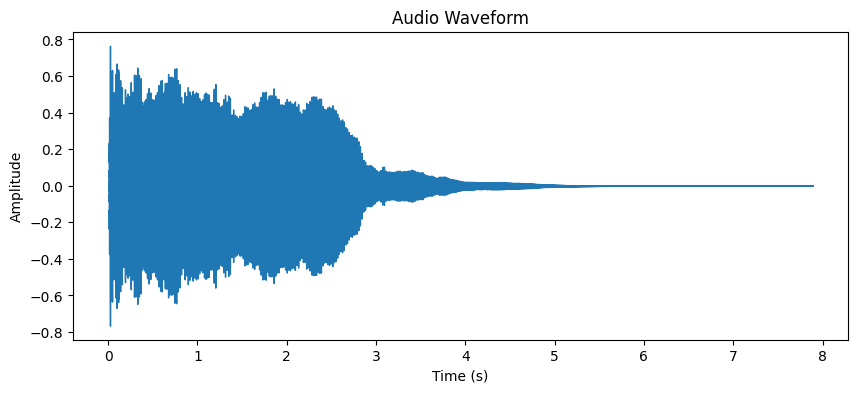

In [121]:
import librosa.display

plt.figure()
librosa.display.waveshow(audio, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


## 3. Compute and Visualize the Spectrogram
We use Librosa's STFT to compute the spectrogram and convert it to decibels.


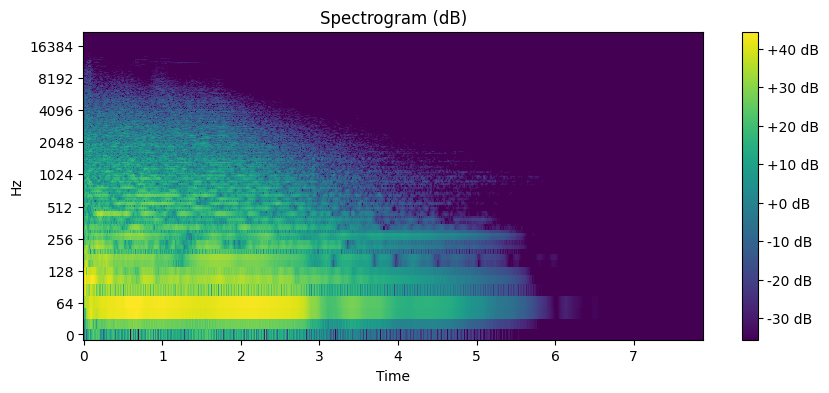

In [122]:
def compute_spectrogram(audio, sr):
    """Compute a spectrogram in dB using Librosa."""
    S = librosa.stft(audio)
    spectrogram_db = librosa.amplitude_to_db(np.abs(S))
    return spectrogram_db

spectrogram_db = compute_spectrogram(audio, sr)

plt.figure()
librosa.display.specshow(spectrogram_db, sr=sr, x_axis="time", y_axis="log", cmap="viridis")
plt.title("Spectrogram (dB)")
plt.colorbar(format='%+2.0f dB')
plt.show()


## 4. Detect Peaks in the Spectrogram
We'll apply a maximum filter and use the 10th percentile (adjustable via LOUDNESS_GATE) as the threshold.


Detected 934 peaks in the trimmed spectrogram.


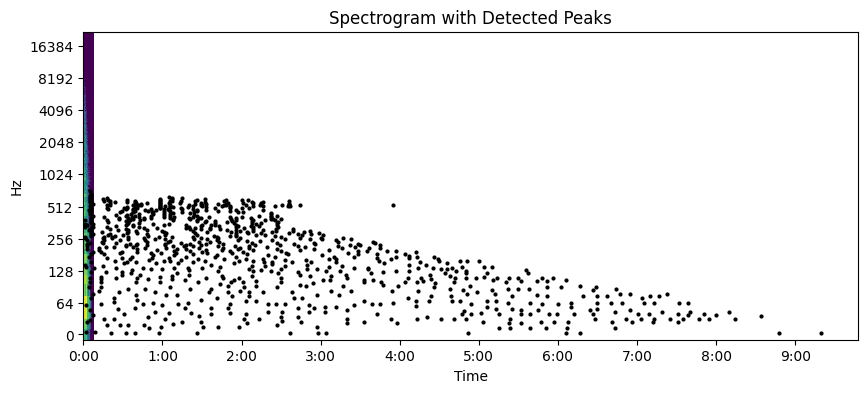

In [123]:
# %% [code]
def get_peaks(spectrogram, threshold=LOUDNESS_GATE):
    # Apply a 10x10 max filter to detect local maximums.
    max_filt = maximum_filter(spectrogram, size=(10, 10))
    # Create a boolean mask of peaks: only those that are local max AND above the threshold percentile.
    peaks_bool = (spectrogram == max_filt) & (spectrogram > np.percentile(spectrogram, threshold))
    # Get the (frequency index, time frame index) coordinates of these peaks.
    peak_coords = np.column_stack(np.where(peaks_bool))
    return peak_coords

peaks = get_peaks(spectrogram_db)
print(f"Detected {len(peaks)} peaks in the trimmed spectrogram.")

# Visualize the peaks on the spectrogram
plt.figure()
librosa.display.specshow(spectrogram_db, sr=sr, x_axis="time", y_axis="log", cmap="viridis")
if peaks.size > 0:
    plt.plot(peaks[:, 1], peaks[:, 0], 'ko', markersize=2)  # black dots
plt.title("Spectrogram with Detected Peaks")
plt.show()


## 5. Generate Fingerprint Hashes from Peaks
Each peak is paired with a few subsequent peaks (the number determined by FAN_VALUE).  
We'll generate hashes and count them.


In [124]:
def _generate_hashes_for_index(i, peaks, fan_value=FAN_VALUE):
    """Generate hash pairs for a given index."""
    local_hashes = []
    for j in range(1, fan_value):
        if i + j < len(peaks):
            freq1, time1 = peaks[i]
            freq2, time2 = peaks[i + j]
            hash_str = f"{freq1}|{freq2}|{time2 - time1}"
            hash_val = xxhash.xxh64(hash_str.encode()).hexdigest()[:10]
            local_hashes.append((hash_val, time1))
    return local_hashes

def generate_hashes(peaks, fan_value=FAN_VALUE):
    """Generate fingerprint hashes from detected peaks."""
    hashes = []
    for i in range(len(peaks)):
        hashes.extend(_generate_hashes_for_index(i, peaks, fan_value))
    return hashes

hashes = generate_hashes(peaks)
print(f"Generated {len(hashes)} hashes using a fan value of {FAN_VALUE}")


Generated 3726 hashes using a fan value of 5


## 6. Analyze Hash Collisions
Let's see how often the same hash value appears. A high level of collisions may indicate that the fingerprint is not discriminative enough.


Total unique hashes: 3656


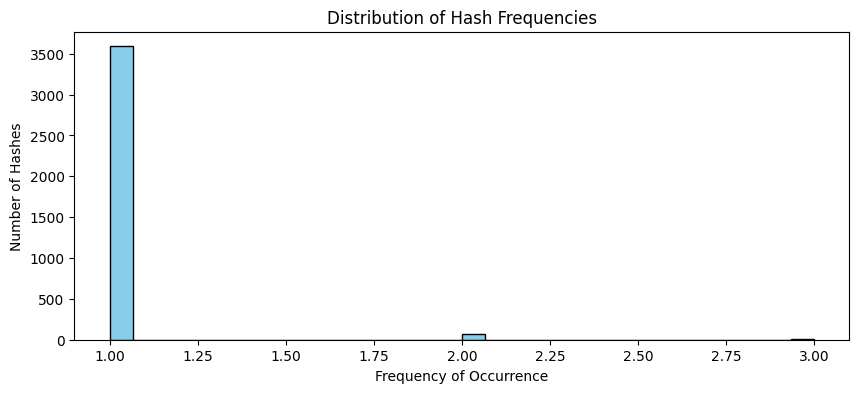

In [125]:
hash_values = [h for h, t in hashes]
hash_counts = Counter(hash_values)
unique_hashes = len(hash_counts)
print(f"Total unique hashes: {unique_hashes}")

# Plot histogram of hash frequencies (how many times each hash appears)
plt.figure()
plt.hist(hash_counts.values(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Hash Frequencies")
plt.xlabel("Frequency of Occurrence")
plt.ylabel("Number of Hashes")
plt.show()


## 7. Observations and Parameter Tuning
- If you see an extremely high number of generated hashes or many collisions, consider increasing the **LOUDNESS_GATE** to filter out lower-energy peaks.
- Reducing the **FAN_VALUE** will also produce fewer hashes.
- Try changing the **SAMPLING_RATE** to see its effect on the resolution of your spectrogram.

You can update the variables `SAMPLING_RATE`, `LOUDNESS_GATE`, and `FAN_VALUE` at the top of this notebook or use interactive widgets (like ipywidgets) for more dynamic adjustments.

---

# Conclusion

This notebook walks through the entire audio processing workflow for SeekTune. The visualizations provided help you understand where peaks are detected in the spectrogram and how many hashes are generated (and how they collide). Adjust these parameters based on your observations to reduce collision rates and improve fingerprint discrimination.

Feel free to add additional cells for further experimentation.
